In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import seaborn as sns
import datetime
from matplotlib import pyplot as plt
from pymongo import MongoClient
from smartenergy.database import MinuteMeasurements, HourlyMeasurements, BasicPreprocessor

from IPython.core.display import display, HTML
from jupyterthemes import jtplot
jtplot.style('onedork')

np.warnings.filterwarnings('ignore')
pd.options.display.float_format = '{:.2f}'.format
display(HTML("<style>.container { width: 1600px !important; }</style>"))

capacities_w_h = {
    "30": 371,
    "32": 204,
    "34": 166,
    "37": 115,
    "40": 303,
    "43": 136,
    "47": 150,
    "48": 205,
    "68": 194,
    "71": 402,
    "97": 597,
    "190": 67,
    "309": 199,
    "344": 71,
    "345": 504,
    "366": 340,
    "369": 77,
}

def get_battery_capacities(stations=capacities_w_h.keys(), scaling_factor=1000):
    return {station: capacities_w_h[station] * scaling_factor for station in stations}


DEBUG:2018-09-08 18:53:14,500:matplotlib.backends:::backend module://ipykernel.pylab.backend_inline version unknown


In [7]:
minute_measurements = MinuteMeasurements()
hourly_measurements = HourlyMeasurements()
preprocessor = BasicPreprocessor()
stations = minute_measurements.station_ids

data = minute_measurements.load_multiple_stations(stations)
print(data.shape)
data.sample(5)

(1186431, 67)


EE/(SG+Bat) EE/SG E_Excess E_Excess_1     E_Load  E_LoadDirect  \
39694          0%    0%        0        NaN   23,15824     -11,46628   
66981          0%    0%        0        NaN    0,21861  -0,065496667   
60106          1%    8%        0        NaN   30,19575      17,94455   
981            4%  143%        0        NaN  111,58503      83,82534   
19829          0%    0%        0        NaN  2193,3296      -9,66416   

      E_LoadDirect_1 E_Load_1         E_PV E_PV_1    ...     u32Grid_mode  \
39694            NaN      NaN  4,581066667    NaN    ...              nan   
66981            NaN      NaN  6,299186667    NaN    ...             5.00   
60106            NaN      NaN      5,31112    NaN    ...              nan   
981              NaN      NaN  3,365333333    NaN    ...              nan   
19829            NaN      NaN   1799,41928    NaN    ...              nan   

      u32Load_mode u32OperationMode u32PV_mode u32TimeDelta_device  \
39694          nan               41        nan                 nan   
66981         1.00              151       1.00                 nan   
60106          nan               61        nan                 nan   
981            nan              181        nan                 nan   
19829          nan              121        nan                 nan   

            u32TimeStamp  u32TotalBought u32TotalSold u8StateOfBattery  \
39694  31/12/17 02:26:30           30510           40                0   
66981  19/03/18 18:47:33           31097           40                3   
60106  11/02/18 00:24:16            1186       101759                2   
981    31/10/17 11:43:17            7541         5095                3   
19829  01/12/17 21:35:48           12650         7221                1   

      u8UserMode  
39694          0  
66981          0  
60106          0  
981            0  
19829          0  

[5 rows x 67 columns]

In [10]:
data = preprocessor(data)

In [ ]:
sum_stats = {key: np.sum for key in ['energy_production_i', 'energy_consumption_i', 'energy_consumption_computed_i', 'energy_production_computed_i',
                                     'energy_to_grid_i', 'energy_to_battery_i']} 
mean_stats = {key: np.mean for key in ['temperature']} 
last_stats = {key: 'last' for key in ['battery_state_discrete']} 
stats = {**sum_stats, **mean_stats, **last_stats}

data_hourly = preprocessor.group_data_hourly(data[vars_of_interest], stats)
#hourly_measurements.drop()
#hourly_measurements.insert_many(data_hourly.reset_index().to_dict('records'))
print(data_hourly.shape)
data_hourly.head()

### Analyzing untracked energy going to the battery

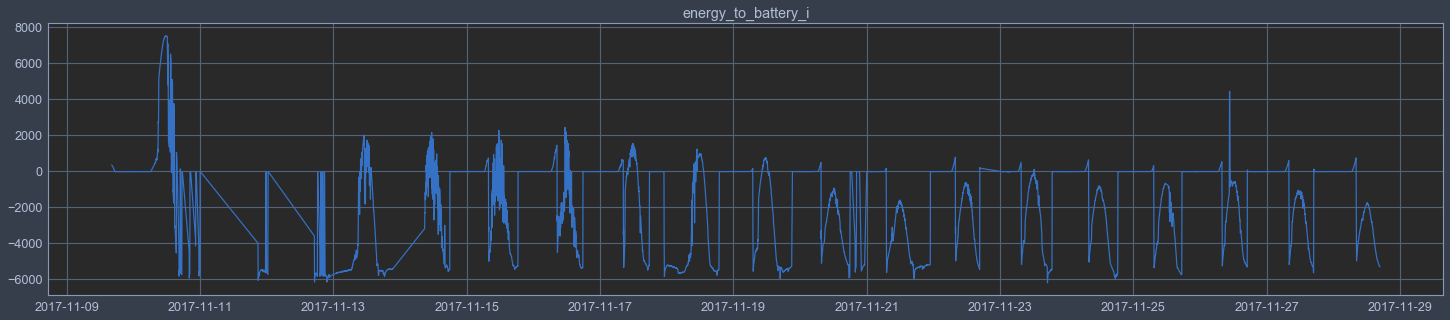

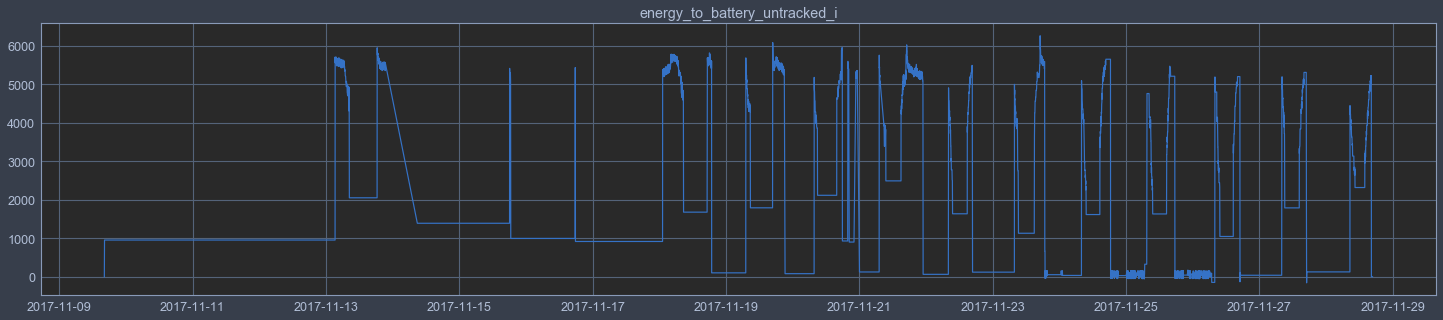

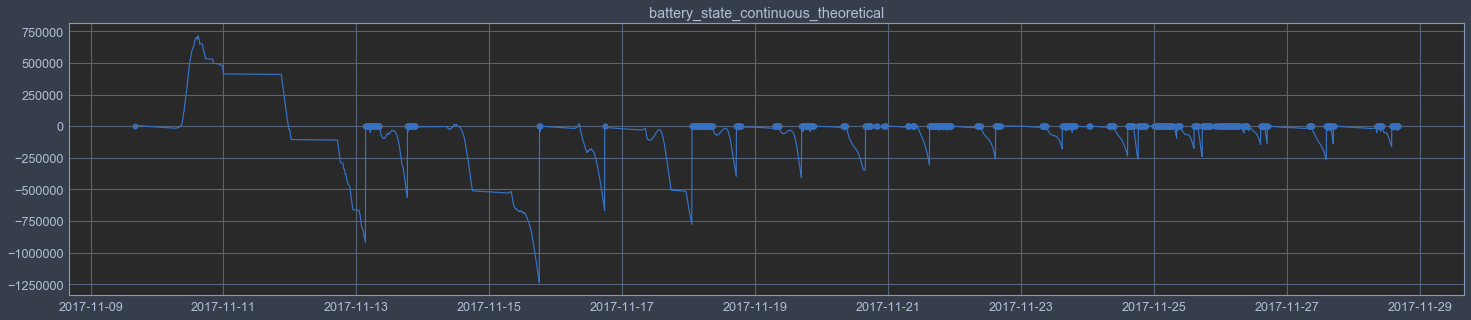

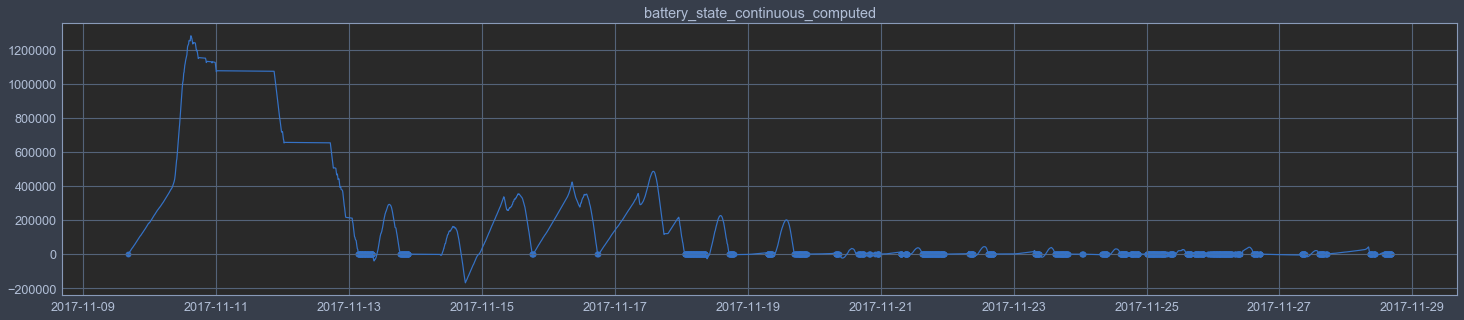

In [17]:
import random
import seaborn as sns
from matplotlib import pyplot as plt
import matplotlib

station = random.choice(range(3))
for var in ['energy_to_battery_i', 'energy_to_battery_untracked_i', 'battery_state_continuous_theoretical', 'battery_state_continuous_computed']:
    fig, ax = plt.subplots(1, 1, figsize=(25, 5))
    plt.plot(data.loc[data.reset_index()['solbox_id'].unique()[station]].reset_index().set_index('datetime')[var])
    if var in ['battery_state_continuous_theoretical', 'battery_state_continuous_computed']:
        _data = data.loc[data.reset_index()['solbox_id'].unique()[station]].reset_index()
        plt.scatter(_data['datetime'].values, _data['battery_state_continuous_at_change'].values)
    plt.title(var)
    ax.set_facecolor('#292929')
    plt.show()

In [32]:
data['energy_to_battery_untracked_i'].abs().groupby('solbox_id').sum() / data['energy_to_battery_i'].abs().groupby('solbox_id').sum()

solbox_id
48   0.72
68   0.94
71   0.86
dtype: float64

### Analyze missingness patterns

In [ ]:
minute_measurements = MinuteMeasurements()
hourly_measurements = HourlyMeasurements()
preprocessor = BasicPreprocessor()
stations = minute_measurements.station_ids

data = minute_measurements.load_multiple_stations(stations)
data = preprocessor.transform(data)
print(data.shape)
data.sample(5)

In [11]:
dates_list = list()
for _id in stations:
    min_date, max_date = min(data.loc[_id].reset_index()['datetime']), max(data.loc[_id].reset_index()['datetime'])
    _dates = pd.date_range(min_date, max_date, freq='2min')
    dates = pd.DataFrame({
        'datetime': _dates,
        'solbox_id': [_id] * len(_dates),
    })
    dates_list.append(dates)

dates = pd.concat(dates_list).set_index(['solbox_id', 'datetime'])
print(dates.head())
print(dates.shape)
data = data.join(dates, how='outer')

KeyError: 'the label [48] is not in the [index]'

In [173]:
loads = hourly_data['fILoadDirect_avg']

In [179]:
loads.rolling(24, 12).mean().isnull().head()

solbox_id  datetime           
190        2018-01-28 11:00:00    True
           2018-01-28 12:00:00    True
           2018-01-28 13:00:00    True
           2018-01-28 14:00:00    True
           2018-01-28 15:00:00    True
Name: fILoadDirect_avg, dtype: bool

In [196]:
loads = hourly_data['fILoadDirect_avg'].copy()
print(loads.isnull().sum())
loads.loc[loads.isnull()] = loads.rolling(24, 12).mean().loc[loads.isnull()]
loads.head()
print(loads.isnull().sum())

6785
6097


In [152]:
hourly_data.head()

day  fIExcess_avg  fILoadDirect_avg  \
solbox_id datetime                                                    
190       2018-01-28 11:00:00 28.00          0.79            763.10   
          2018-01-28 12:00:00   nan           nan               nan   
          2018-01-28 13:00:00   nan           nan               nan   
          2018-01-28 14:00:00   nan           nan               nan   
          2018-01-28 15:00:00   nan           nan               nan   

                               fILoad_avg  fIPV_avg  fIToBat_avg  \
solbox_id datetime                                                 
190       2018-01-28 11:00:00     2533.30   1142.58         0.00   
          2018-01-28 12:00:00         nan       nan          nan   
          2018-01-28 13:00:00         nan       nan          nan   
          2018-01-28 14:00:00         nan       nan          nan   
          2018-01-28 15:00:00         nan       nan          nan   

                               fIToGrid_avg  fTemperature_avg  hour  month  \
solbox_id datetime                                                           
190       2018-01-28 11:00:00          0.00             23.75 11.00   1.00   
          2018-01-28 12:00:00           nan               nan   nan    nan   
          2018-01-28 13:00:00           nan               nan   nan    nan   
          2018-01-28 14:00:00           nan               nan   nan    nan   
          2018-01-28 15:00:00           nan               nan   nan    nan   

                               u8StateOfBattery    year  
solbox_id datetime                                       
190       2018-01-28 11:00:00              2.00 2018.00  
          2018-01-28 12:00:00               nan     nan  
          2018-01-28 13:00:00               nan     nan  
          2018-01-28 14:00:00               nan     nan  
          2018-01-28 15:00:00               nan     nan

In [131]:
rolling_data.set_index(['solbox_id', 'datetime']).head()

level_1  fIExcess_avg  fILoadDirect_avg  \
solbox_id datetime                                                       
190       2018-01-28 11:00:00        0           nan               nan   
          2018-01-28 12:00:00        1           nan               nan   
          2018-01-28 13:00:00        2           nan               nan   
          2018-01-28 14:00:00        3           nan               nan   
          2018-01-28 15:00:00        4           nan               nan   

                               fILoad_avg  fIPV_avg  fIToBat_avg  \
solbox_id datetime                                                 
190       2018-01-28 11:00:00         nan       nan          nan   
          2018-01-28 12:00:00         nan       nan          nan   
          2018-01-28 13:00:00         nan       nan          nan   
          2018-01-28 14:00:00         nan       nan          nan   
          2018-01-28 15:00:00         nan       nan          nan   

                               fIToGrid_avg  fTemperature_avg  \
solbox_id datetime                                              
190       2018-01-28 11:00:00           nan               nan   
          2018-01-28 12:00:00           nan               nan   
          2018-01-28 13:00:00           nan               nan   
          2018-01-28 14:00:00           nan               nan   
          2018-01-28 15:00:00           nan               nan   

                               u8StateOfBattery  
solbox_id datetime                               
190       2018-01-28 11:00:00               nan  
          2018-01-28 12:00:00               nan  
          2018-01-28 13:00:00               nan  
          2018-01-28 14:00:00               nan  
          2018-01-28 15:00:00               nan

In [197]:
hourly_data.columns

Index(['day', 'fIExcess_avg', 'fILoadDirect_avg', 'fILoad_avg', 'fIPV_avg',
       'fIToBat_avg', 'fIToGrid_avg', 'fTemperature_avg', 'hour', 'month',
       'u8StateOfBattery', 'year'],
      dtype='object')

In [ ]:
features_to_fill = ['fIExcess_avg', 'fILoadDirect_avg', 'fILoad_avg', 'fIPV_avg',
                    'fIToBat_avg', 'fIToGrid_avg', 'fTemperature_avg']

In [170]:
for var in features_to_fill:
    _var = hourly_data[var]
    hourly_data = hourly_data[var].reset_index().drop(['datetime', 'year', 'hour', 'month', 'day'], axis=1).copy()
    rolling_data = full_data\
        .groupby('solbox_id').rolling(24, min_periods=1).mean()\
        .drop('solbox_id', axis=1).reset_index()
    rolling_data['datetime'] = hourly_data.reset_index()['datetime']
    full_data[full_data.isnull()] = rolling_data.set_index(['solbox_id', 'datetime'])[full_data.isnull()]

ValueError: cannot join with no level specified and no overlapping names

In [171]:
rolling_data.head()

solbox_id  level_1  fIExcess_avg  fILoadDirect_avg  fILoad_avg  fIPV_avg  \
0       190        0          0.79            763.10     2533.30   1142.58   
1       190        1          0.79            763.10     2533.30   1142.58   
2       190        2          0.79            763.10     2533.30   1142.58   
3       190        3          0.79            763.10     2533.30   1142.58   
4       190        4          0.79            763.10     2533.30   1142.58   

   fIToBat_avg  fIToGrid_avg  fTemperature_avg  u8StateOfBattery  \
0         0.00          0.00             23.75              2.00   
1         0.00          0.00             23.75              2.00   
2         0.00          0.00             23.75              2.00   
3         0.00          0.00             23.75              2.00   
4         0.00          0.00             23.75              2.00   

             datetime  
0 2018-01-28 11:00:00  
1 2018-01-28 12:00:00  
2 2018-01-28 13:00:00  
3 2018-01-28 14:00:00  
4 2018-01-28 15:00:00

In [169]:
full_data.head()

day  fIExcess_avg  fILoadDirect_avg  \
solbox_id datetime                                                    
190       2018-01-28 11:00:00 28.00          0.79            763.10   
          2018-01-28 12:00:00   nan          0.79            763.10   
          2018-01-28 13:00:00   nan          0.79            763.10   
          2018-01-28 14:00:00   nan          0.79            763.10   
          2018-01-28 15:00:00   nan          0.79            763.10   

                               fILoad_avg  fIPV_avg  fIToBat_avg  \
solbox_id datetime                                                 
190       2018-01-28 11:00:00     2533.30   1142.58         0.00   
          2018-01-28 12:00:00     2533.30   1142.58         0.00   
          2018-01-28 13:00:00     2533.30   1142.58         0.00   
          2018-01-28 14:00:00     2533.30   1142.58         0.00   
          2018-01-28 15:00:00     2533.30   1142.58         0.00   

                               fIToGrid_avg  fTemperature_avg  hour  month  \
solbox_id datetime                                                           
190       2018-01-28 11:00:00          0.00             23.75 11.00   1.00   
          2018-01-28 12:00:00          0.00             23.75   nan    nan   
          2018-01-28 13:00:00          0.00             23.75   nan    nan   
          2018-01-28 14:00:00          0.00             23.75   nan    nan   
          2018-01-28 15:00:00          0.00             23.75   nan    nan   

                               u8StateOfBattery    year  
solbox_id datetime                                       
190       2018-01-28 11:00:00              2.00 2018.00  
          2018-01-28 12:00:00              2.00     nan  
          2018-01-28 13:00:00              2.00     nan  
          2018-01-28 14:00:00              2.00     nan  
          2018-01-28 15:00:00              2.00     nan

In [158]:
full_data.isnull().groupby('solbox_id').mean()['day']

solbox_id
190   0.46
30    0.11
309   0.53
32    0.09
34    0.07
344   0.68
345   0.40
366   0.40
369   0.47
37    0.06
40    0.06
43    0.14
47    0.14
48    0.20
68    0.21
71    0.32
97    0.47
Name: day, dtype: float64

In [159]:
hourly_data.isnull().groupby('solbox_id').mean()['day']

solbox_id
190   0.46
30    0.11
309   0.53
32    0.09
34    0.07
344   0.68
345   0.40
366   0.40
369   0.47
37    0.06
40    0.06
43    0.14
47    0.14
48    0.20
68    0.21
71    0.32
97    0.47
Name: day, dtype: float64

In [124]:
hourly_data[(hourly_data.isnull()) & (~rolling_data.set_index(['solbox_id', 'datetime']).isnull())]

day  fIExcess_avg  fILoadDirect_avg  \
solbox_id datetime                                                   
190       2018-01-28 11:00:00  nan           nan               nan   
          2018-01-28 12:00:00  nan           nan               nan   
          2018-01-28 13:00:00  nan           nan               nan   
          2018-01-28 14:00:00  nan           nan               nan   
          2018-01-28 15:00:00  nan           nan               nan   
          2018-01-28 16:00:00  nan           nan               nan   
          2018-01-28 17:00:00  nan           nan               nan   
          2018-01-28 18:00:00  nan           nan               nan   
          2018-01-28 19:00:00  nan           nan               nan   
          2018-01-28 20:00:00  nan           nan               nan   
          2018-01-28 21:00:00  nan           nan               nan   
          2018-01-28 22:00:00  nan           nan               nan   
          2018-01-28 23:00:00  nan           nan               nan   
          2018-01-29 00:00:00  nan           nan               nan   
          2018-01-29 01:00:00  nan           nan               nan   
          2018-01-29 02:00:00  nan           nan               nan   
          2018-01-29 03:00:00  nan           nan               nan   
          2018-01-29 04:00:00  nan           nan               nan   
          2018-01-29 05:00:00  nan           nan               nan   
          2018-01-29 06:00:00  nan           nan               nan   
          2018-01-29 07:00:00  nan           nan               nan   
          2018-01-29 08:00:00  nan           nan               nan   
          2018-01-29 09:00:00  nan           nan               nan   
          2018-01-29 10:00:00  nan           nan               nan   
          2018-01-29 11:00:00  nan           nan               nan   
          2018-01-29 12:00:00  nan           nan               nan   
          2018-01-29 13:00:00  nan           nan               nan   
          2018-01-29 14:00:00  nan           nan               nan   
          2018-01-29 15:00:00  nan           nan               nan   
          2018-01-29 16:00:00  nan           nan               nan   
...                            ...           ...               ...   
97        2018-05-07 09:00:00  nan           nan               nan   
          2018-05-07 10:00:00  nan           nan               nan   
          2018-05-07 11:00:00  nan           nan               nan   
          2018-05-07 12:00:00  nan           nan               nan   
          2018-05-07 13:00:00  nan           nan               nan   
          2018-05-07 14:00:00  nan           nan               nan   
          2018-05-07 15:00:00  nan           nan               nan   
          2018-05-07 16:00:00  nan           nan               nan   
          2018-05-07 17:00:00  nan           nan               nan   
          2018-05-07 18:00:00  nan           nan               nan   
          2018-05-07 19:00:00  nan           nan               nan   
          2018-05-07 20:00:00  nan           nan               nan   
          2018-05-07 21:00:00  nan           nan               nan   
          2018-05-07 22:00:00  nan           nan               nan   
          2018-05-07 23:00:00  nan           nan               nan   
          2018-05-08 00:00:00  nan           nan               nan   
          2018-05-08 01:00:00  nan           nan               nan   
          2018-05-08 02:00:00  nan           nan               nan   
          2018-05-08 03:00:00  nan           nan               nan   
          2018-05-08 04:00:00  nan           nan               nan   
          2018-05-08 05:00:00  nan           nan               nan   
          2018-05-08 06:00:00  nan           nan               nan   
          2018-05-08 07:00:00  nan           nan               nan   
          2018-05-08 08:00:00  nan           nan               nan   
          2018-05-08 09:00:00  nan       

In [99]:
hourly_data.reset_index().drop(['datetime', 'year', 'hour', 'month', 'day'], axis=1).groupby('solbox_id').rolling(1).mean()

solbox_id  fIExcess_avg  fILoadDirect_avg  fILoad_avg  \
solbox_id                                                                
190       0         190.00          0.79            763.10     2533.30   
          1         190.00           nan               nan         nan   
          2         190.00           nan               nan         nan   
          3         190.00           nan               nan         nan   
          4         190.00           nan               nan         nan   
          5         190.00           nan               nan         nan   
          6         190.00           nan               nan         nan   
          7         190.00           nan               nan         nan   
          8         190.00           nan               nan         nan   
          9         190.00           nan               nan         nan   
          10        190.00           nan               nan         nan   
          11        190.00           nan               nan         nan   
          12        190.00           nan               nan         nan   
          13        190.00           nan               nan         nan   
          14        190.00           nan               nan         nan   
          15        190.00           nan               nan         nan   
          16        190.00           nan               nan         nan   
          17        190.00           nan               nan         nan   
          18        190.00           nan               nan         nan   
          19        190.00           nan               nan         nan   
          20        190.00           nan               nan         nan   
          21        190.00           nan               nan         nan   
          22        190.00           nan               nan         nan   
          23        190.00           nan               nan         nan   
          24        190.00           nan               nan         nan   
          25        190.00           nan               nan         nan   
          26        190.00           nan               nan         nan   
          27        190.00           nan               nan         nan   
          28        190.00           nan               nan         nan   
          29        190.00           nan               nan         nan   
...                    ...           ...               ...         ...   
97        58556      97.00          8.41           2830.38    57355.98   
          58557      97.00          7.83           2604.49    54243.14   
          58558      97.00          7.83           2565.95    54827.58   
          58559      97.00          8.70           2857.40    60333.16   
          58560      97.00          6.09           2032.10    42062.80   
          58561      97.00          7.83           2622.65    53700.93   
          58562      97.00         11.73           2265.67    45131.34   
          58563      97.00         11.99           2397.99    47052.57   
          58564      97.00          6.67           2286.22    44737.32   
          58565      97.00          7.54           2574.45    50420.44   
          58566      97.00          4.64           1583.19    31027.04   
          58567      97.00          8.70           2966.29    58170.16   
          58568      97.00          8.41           2863.68    56225.85   
          58569      97.00          8.70           2959.18    58162.74   
          58570      97.00          8.70           2958.95    58160.47   
          58571      97.00          8.70           2956.61    58146.84   
          58572      97.00          8.70           2953.97    58150.02   
          58573      97.00          7.54           2561.65    50391.33   
          58574      97.00          8.70           2954.73    58133.65   
          58575      97.00          7.25           2459.86    48464.65   
          58576      97.00          8.70           2953.73    58138.65   
          58577      

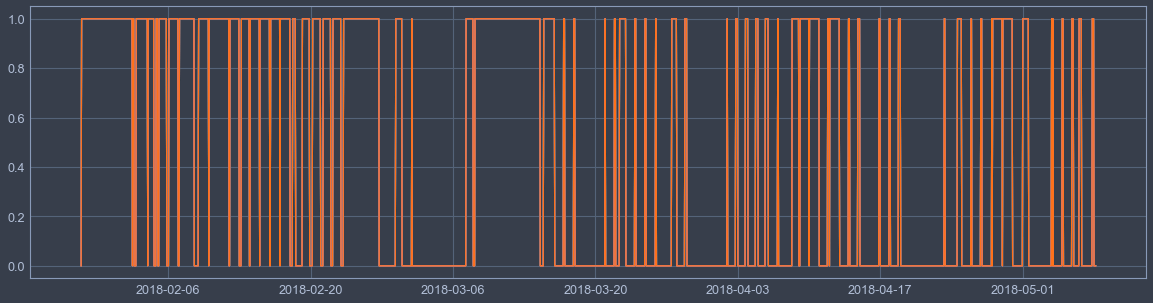

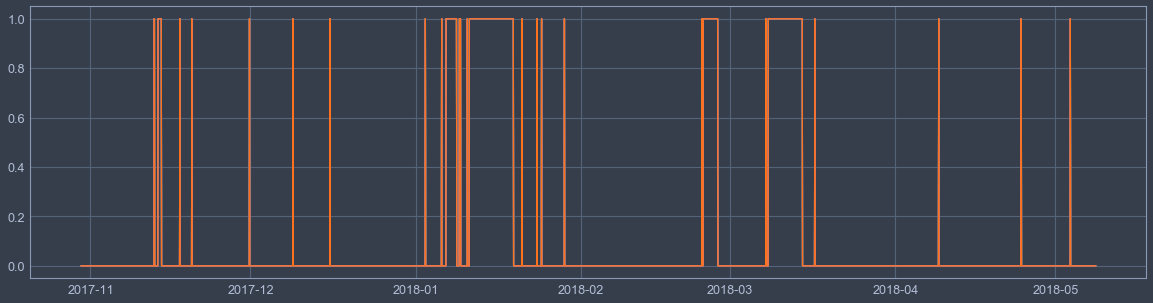

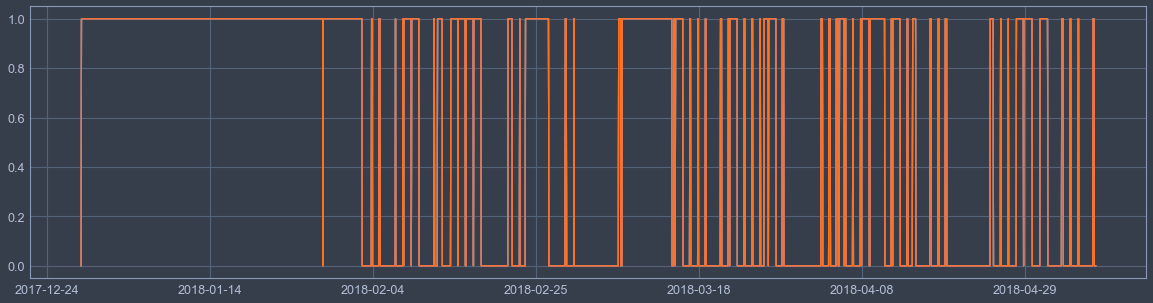

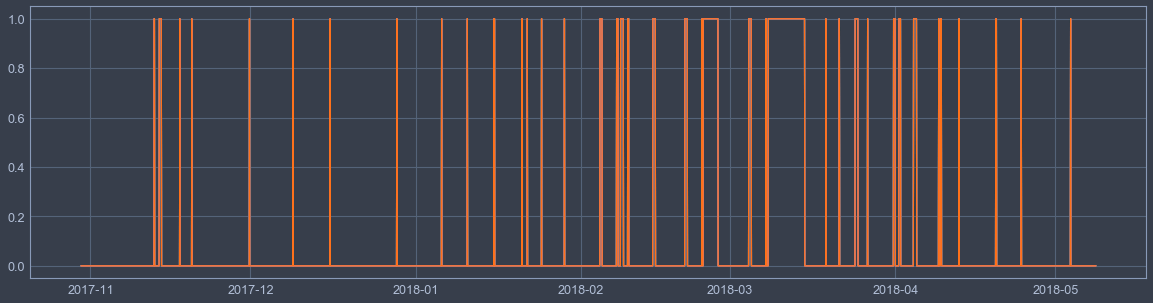

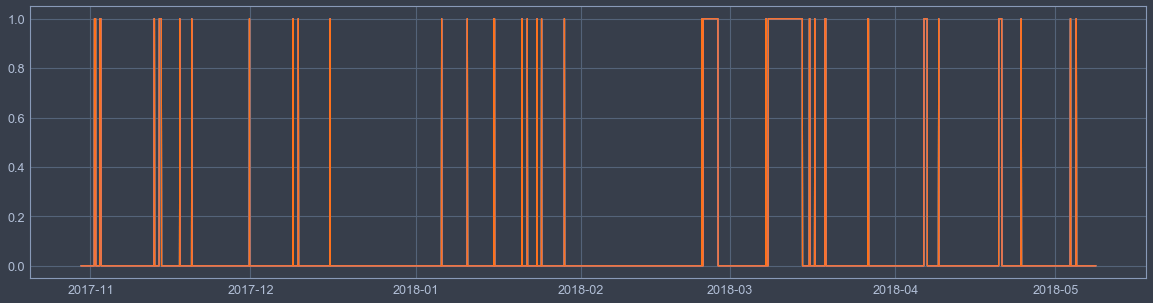

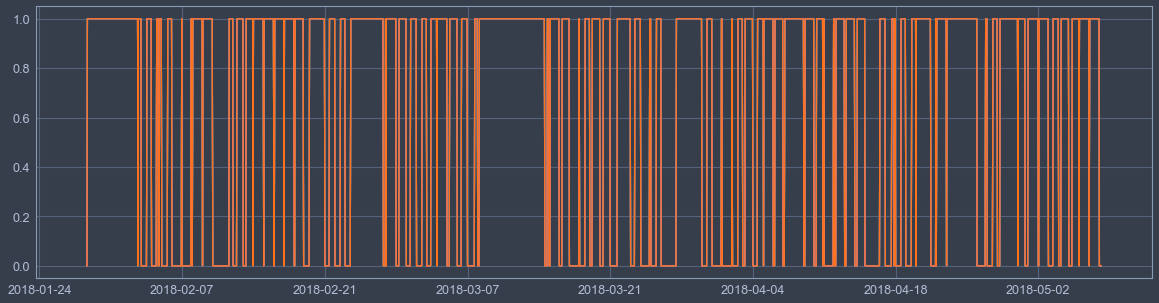

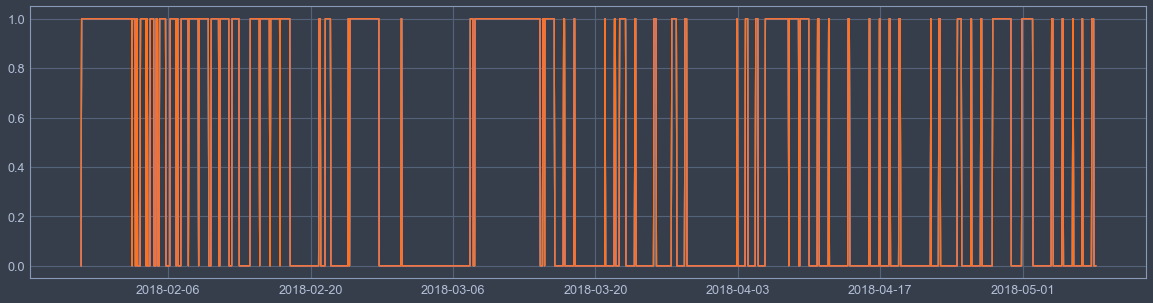

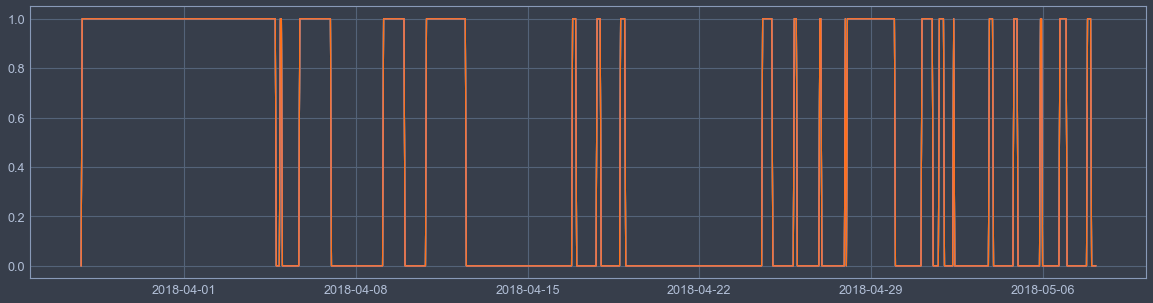

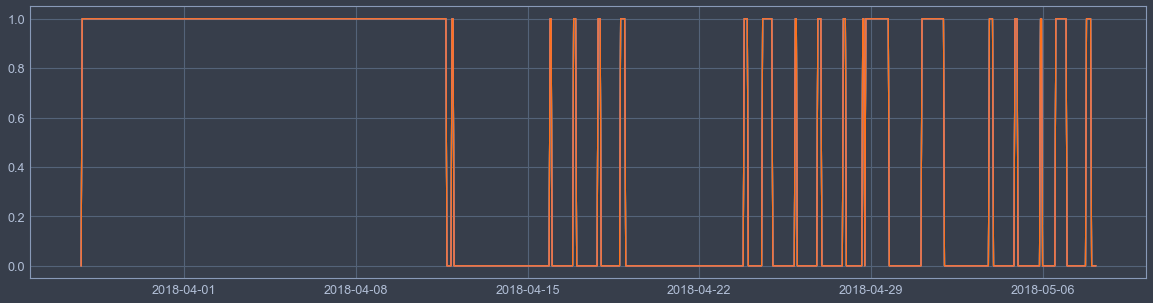

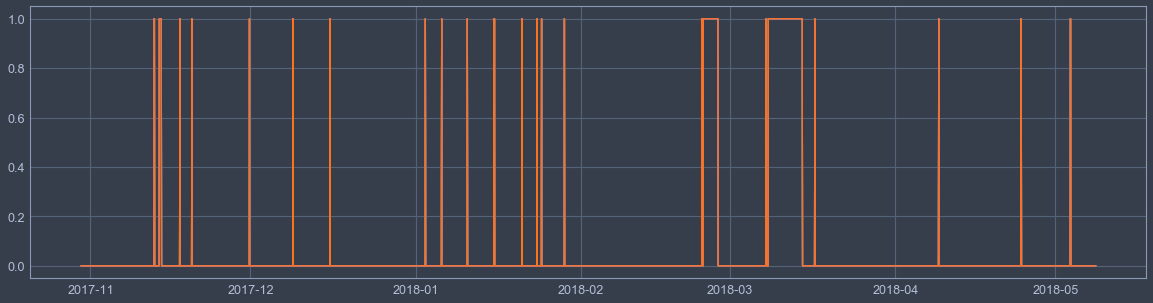

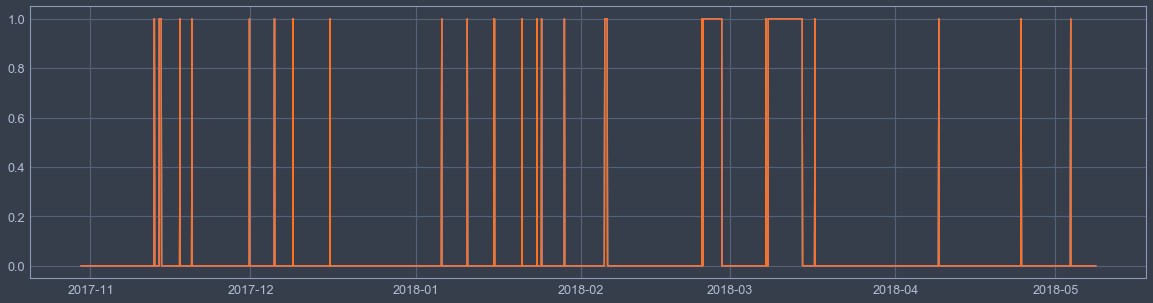

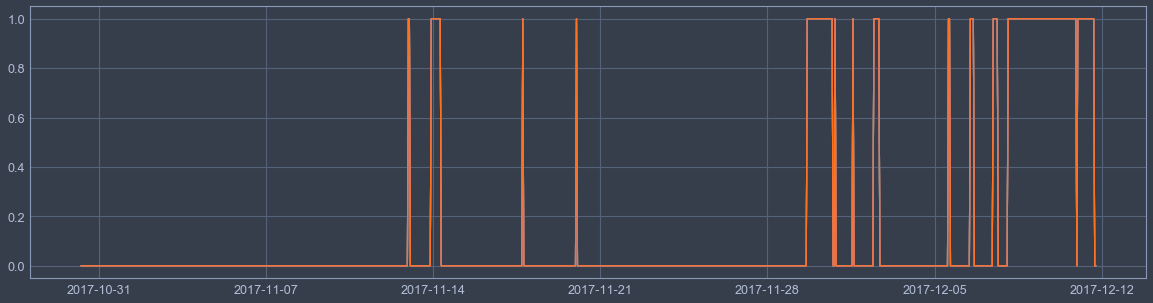

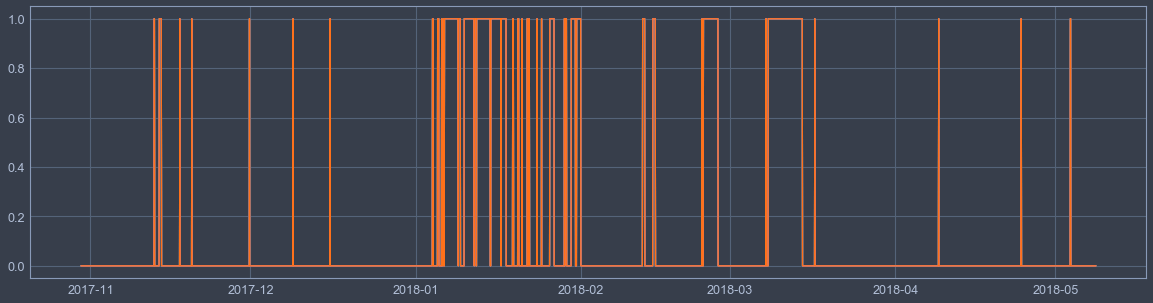

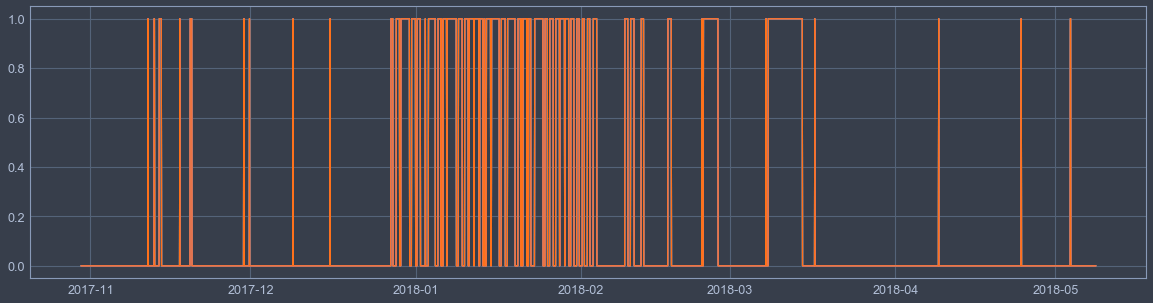

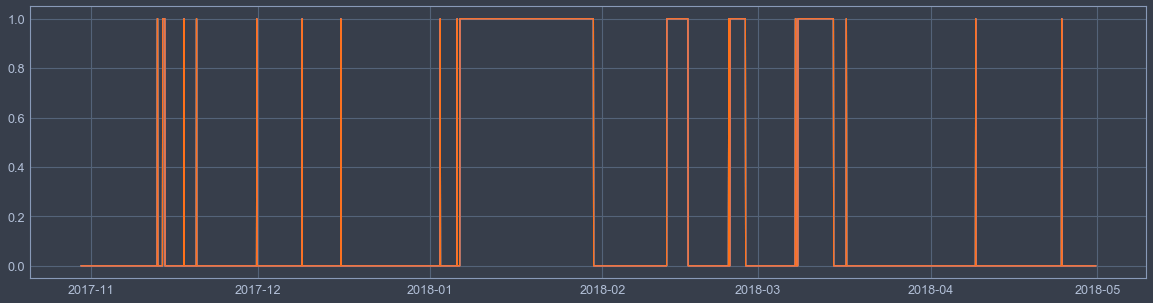

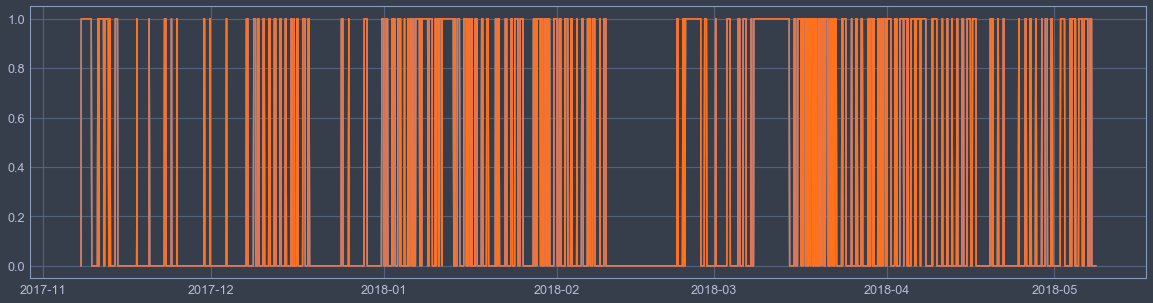

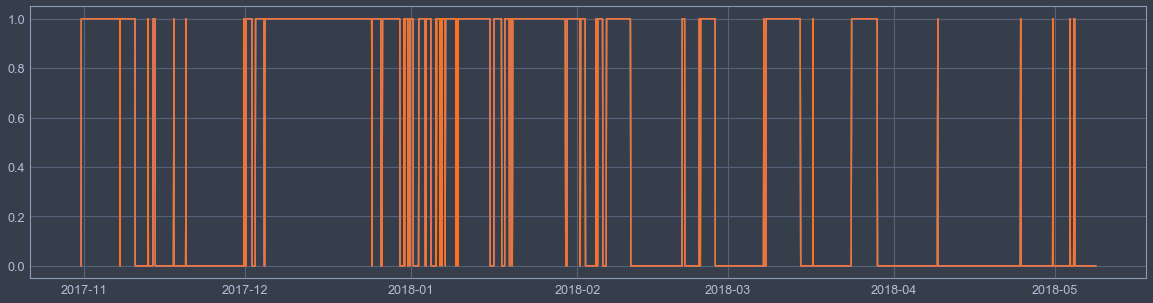

In [78]:
for station in stations:
    plt.figure(figsize=(20, 5))
    plt.plot(hourly_data.isnull().loc[station])
    plt.show()

In [72]:
hourly_data.isnull().groupby('solbox_id')['day'].mean()

solbox_id
190   0.46
30    0.11
309   0.53
32    0.09
34    0.07
344   0.68
345   0.40
366   0.40
369   0.47
37    0.06
40    0.06
43    0.14
47    0.14
48    0.20
68    0.21
71    0.32
97    0.47
Name: day, dtype: float64

### Analyze time patterns on different variables

In [ ]:
hourly_data['computed_load'] = hourly_data['fILoadDirect_avg'] + hourly_data['fIToBat_avg'] + hourly_data['fIToGrid_avg']
hourly_data['load_difference'] = hourly_data['computed_load'] - hourly_data['fILoadDirect_avg'] 
hourly_data['load_direct_difference'] = hourly_data['computed_load'] - hourly_data['fILoad_avg'] 


In [53]:
hourly_data.head()

day  fIExcess_avg  fILoadDirect_avg  \
datetime            solbox_id                                         
2017-10-30 06:00:00 30        30.00          8.41           4317.13   
                    32        30.00          8.41           3260.81   
                    34        30.00          8.41           1275.76   
                    37        30.00          8.41           3209.01   
                    40        30.00          8.70           3902.13   

                               fILoad_avg  fIPV_avg  fIToBat_avg  \
datetime            solbox_id                                      
2017-10-30 06:00:00 30           53931.76  31980.50     -1793.40   
                    32           53797.30  32335.28     -1246.40   
                    34           53144.43  31496.88     -1175.13   
                    37           53923.00  32870.33      -322.86   
                    40           61323.86  35953.17     -4106.18   

                               fIToGrid_avg  fTemperature_avg  hour  month  \
datetime            solbox_id                                                
2017-10-30 06:00:00 30               154.58             26.03  6.00  10.00   
                    32                96.86             24.43  6.00  10.00   
                    34              -159.90             24.48  6.00  10.00   
                    37              -417.40             25.74  6.00  10.00   
                    40              -251.54             32.84  6.00  10.00   

                               u8StateOfBattery    year  computed_load  \
datetime            solbox_id                                            
2017-10-30 06:00:00 30                     3.00 2017.00       30341.68   
                    32                     3.00 2017.00       31185.74   
                    34                     3.00 2017.00       30161.85   
                    37                     3.00 2017.00       32130.07   
                    40                     3.00 2017.00       31595.45   

                               load_difference  load_direct_difference  
datetime            solbox_id                                           
2017-10-30 06:00:00 30                26024.55               -23590.08  
                    32                27924.93               -22611.56  
                    34                28886.09               -22982.58  
                    37                28921.06               -21792.93  
                    40                27693.32               -29728.41

In [17]:
hourly_data[currents].head()

fILoadDirect_avg  fILoad_avg  fIPV_avg  \
solbox_id datetime                                                      
190       2018-01-28 11:00:00            763.10     2533.30   1142.58   
          2018-02-02 12:00:00            134.40     1946.26   1514.66   
          2018-02-02 16:00:00            135.25     1951.17   1190.97   
          2018-02-02 17:00:00            344.26     2166.99   1159.90   
          2018-02-02 18:00:00            583.20     2415.47   1155.39   

                               fIExcess_avg  fIToGrid_avg  fIToBat_avg  \
solbox_id datetime                                                       
190       2018-01-28 11:00:00          0.79          0.00         0.00   
          2018-02-02 12:00:00          0.29        -12.56       281.39   
          2018-02-02 16:00:00          0.38        -14.15       -45.62   
          2018-02-02 17:00:00          0.29        -63.34      -243.32   
          2018-02-02 18:00:00          0.29        -97.24      -462.41   

                               fTemperature_avg  computed_load  \
solbox_id datetime                                               
190       2018-01-28 11:00:00             23.75        1142.58   
          2018-02-02 12:00:00             22.28        2064.88   
          2018-02-02 16:00:00             24.26        1085.58   
          2018-02-02 17:00:00             23.87         609.92   
          2018-02-02 18:00:00             23.40         133.33   

                               load_difference  
solbox_id datetime                              
190       2018-01-28 11:00:00             0.00  
          2018-02-02 12:00:00           550.22  
          2018-02-02 16:00:00          -105.39  
          2018-02-02 17:00:00          -549.98  
          2018-02-02 18:00:00         -1022.06

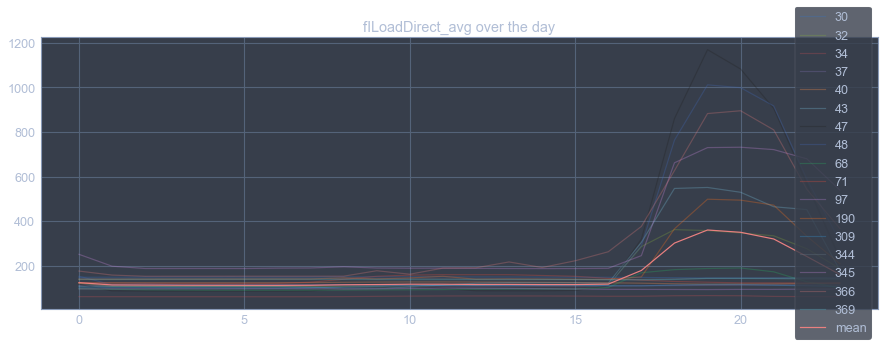

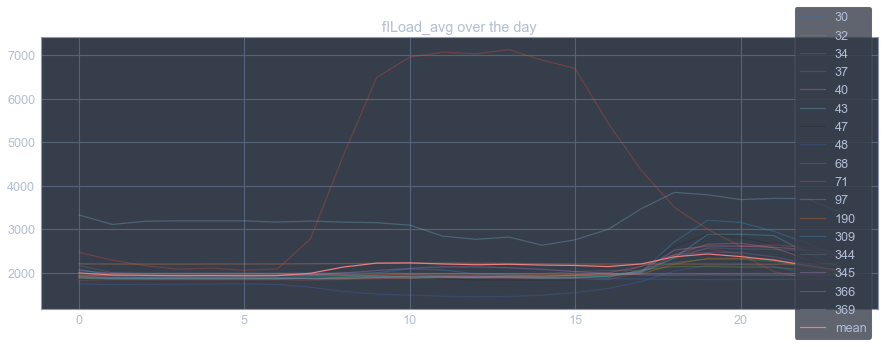

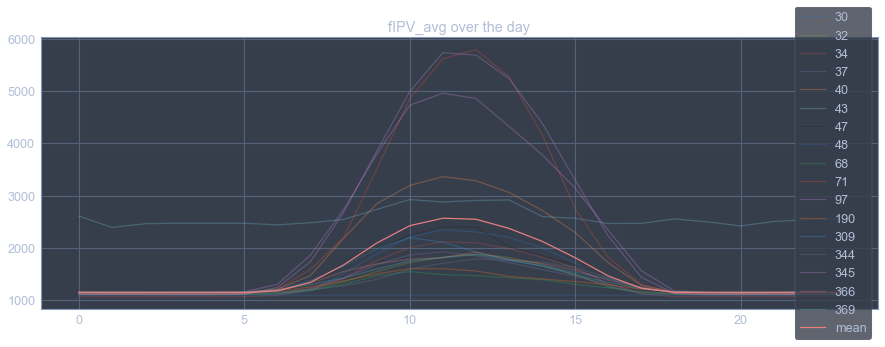

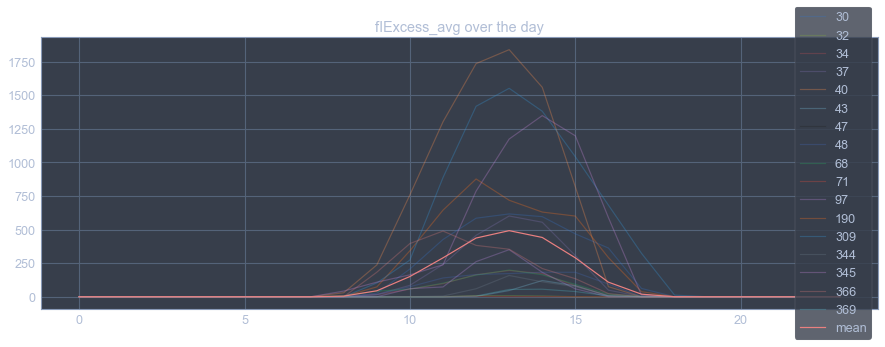

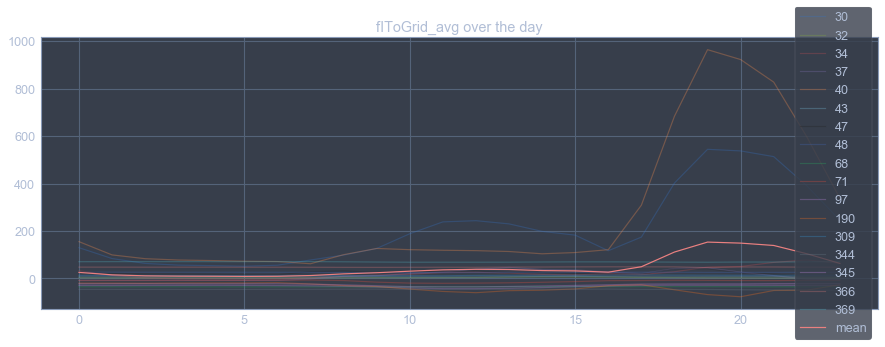

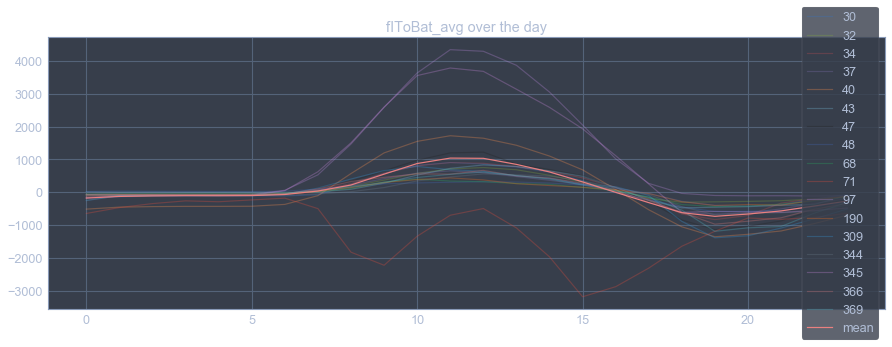

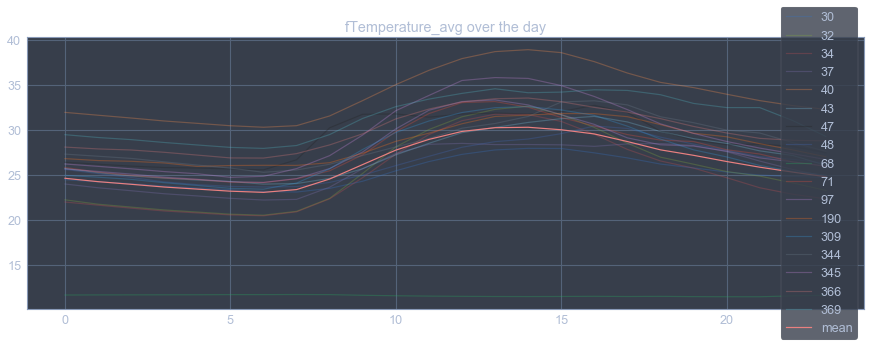

In [5]:
# Visualize currents over the day
for var in currents:
    plt.figure(figsize=(15, 5))
    for station in stations:
        plt.plot(data_hourly.loc[station].groupby('hour')[var].mean(), label=station, alpha=0.3)
        
    plt.plot(data_hourly.groupby('hour')[var].mean(), label='mean')
    plt.title('{} over the day'.format(var))
    plt.legend(loc='right')
    plt.show()

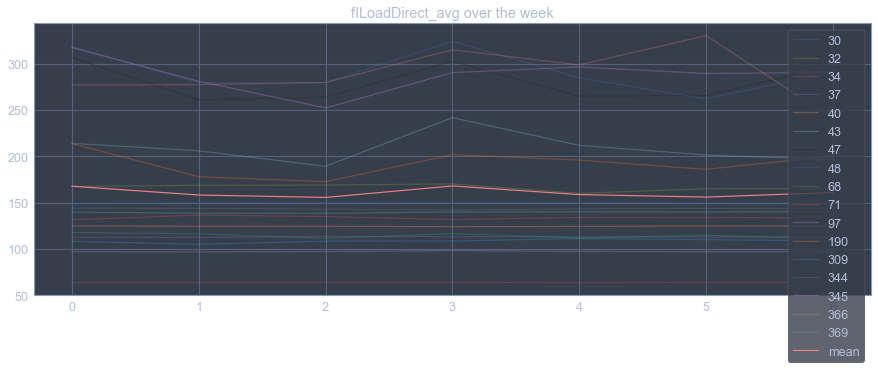

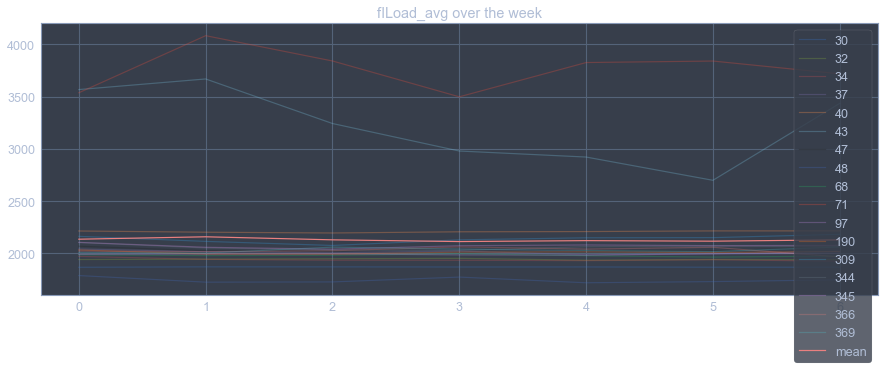

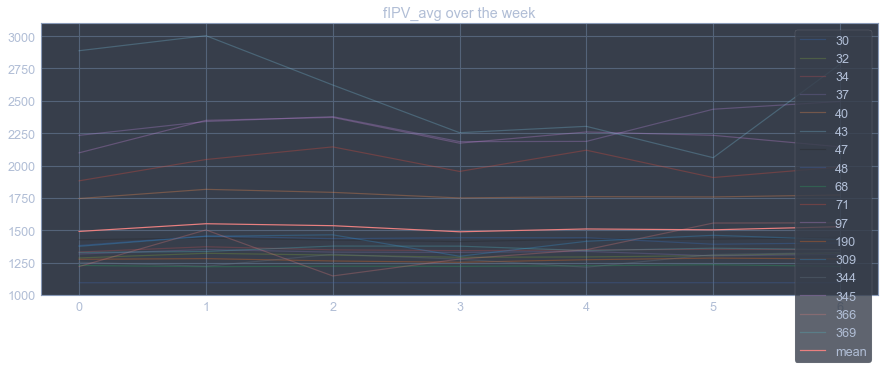

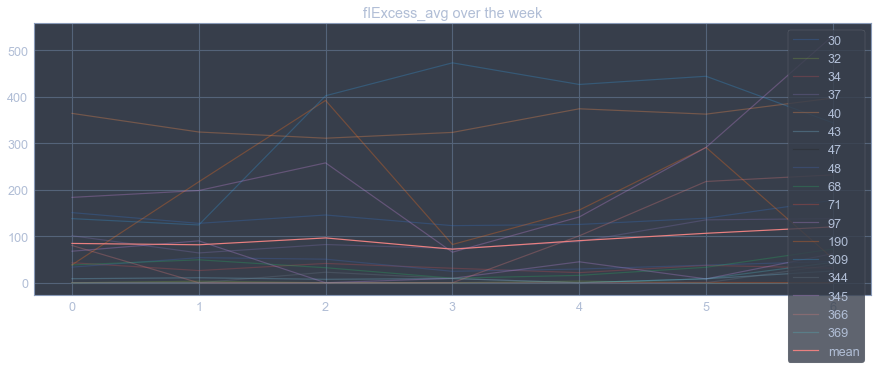

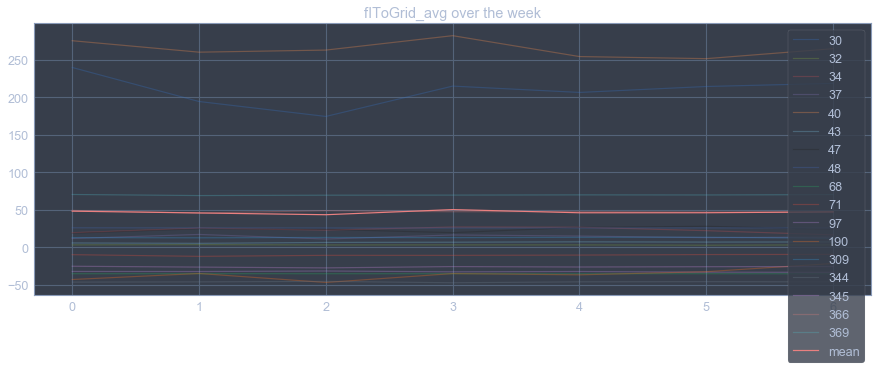

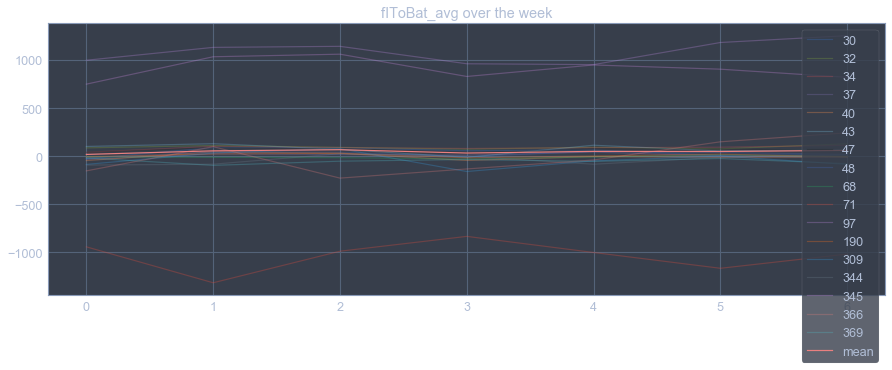

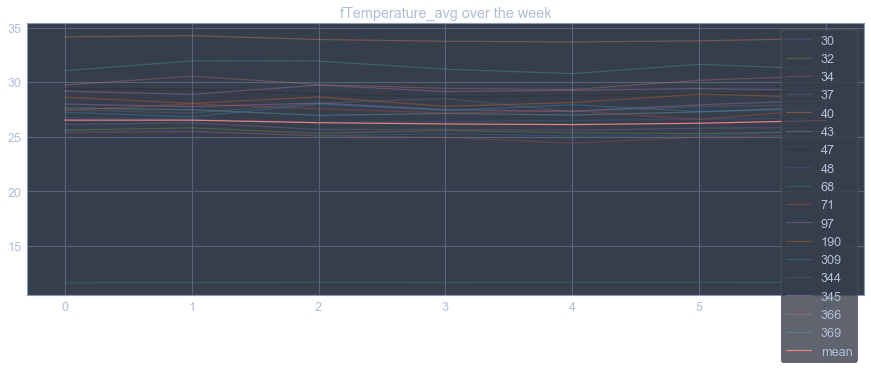

In [6]:
# Visualize voltages over the week
for var in currents:
    plt.figure(figsize=(15, 5))
    for station in stations:
        plt.plot(data_hourly.loc[station].groupby('weekday')[var].mean(), label=station, alpha=0.3)
        
    plt.plot(data_hourly.groupby('weekday')[var].mean(), label='mean')
    plt.title('{} over the week'.format(var))
    plt.legend()
    plt.show()

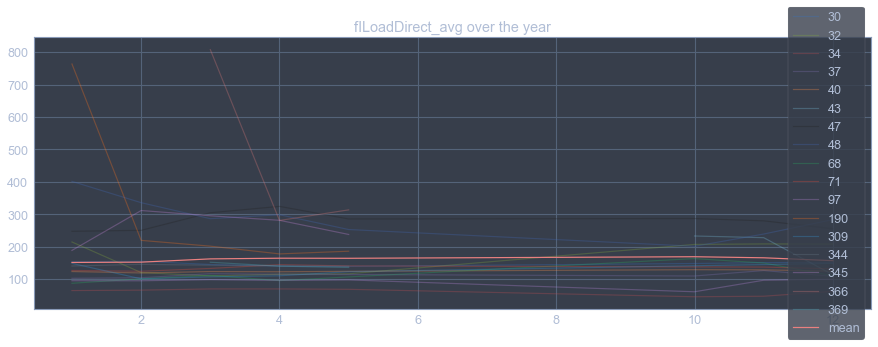

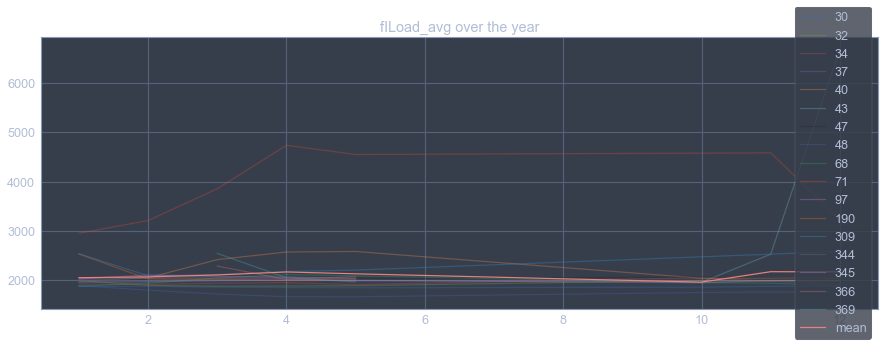

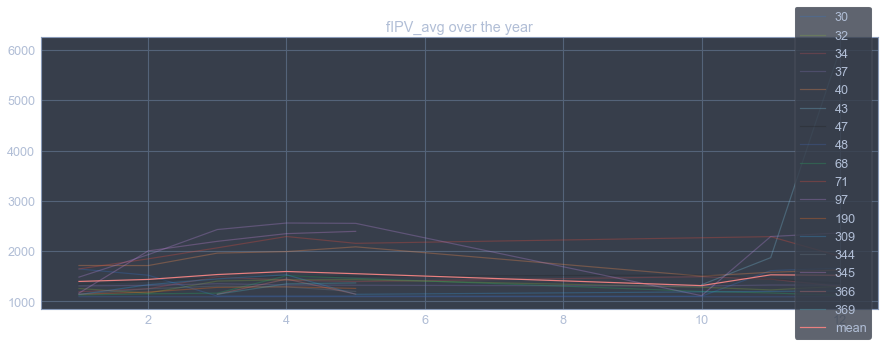

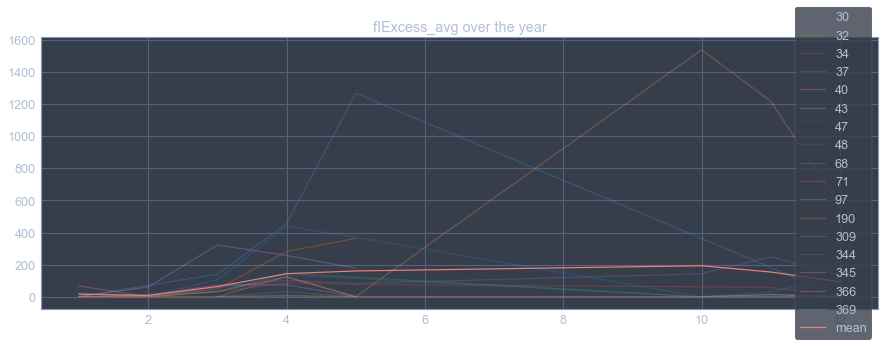

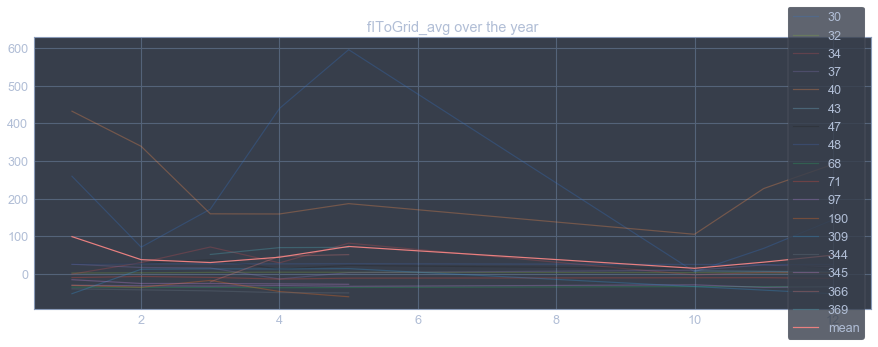

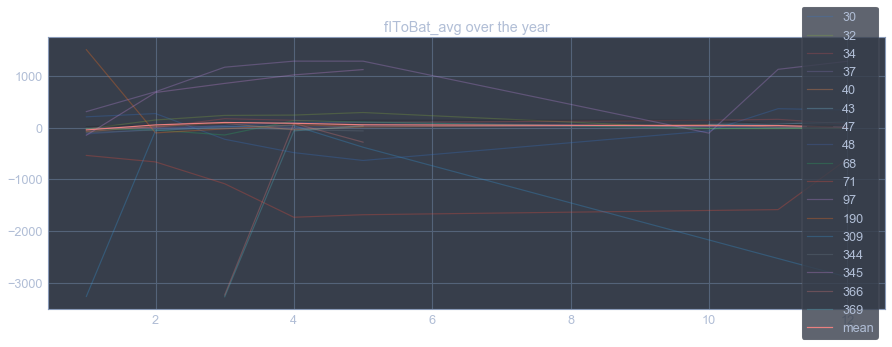

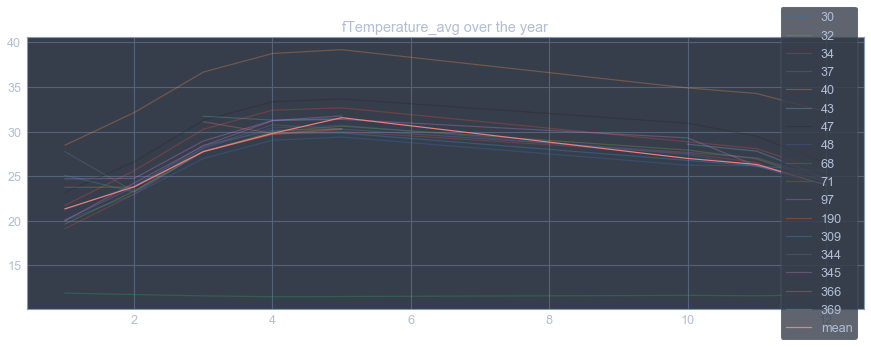

In [7]:
# Visualize voltages over the year
for var in currents:
    plt.figure(figsize=(15, 5))
    for station in stations:
        plt.plot(data_hourly.loc[station].groupby('month')[var].mean(), label=station, alpha=0.3)
        
    plt.plot(data_hourly.groupby('month')[var].mean(), label='mean')
    plt.title('{} over the year'.format(var))
    plt.legend(loc='right')
    plt.show()

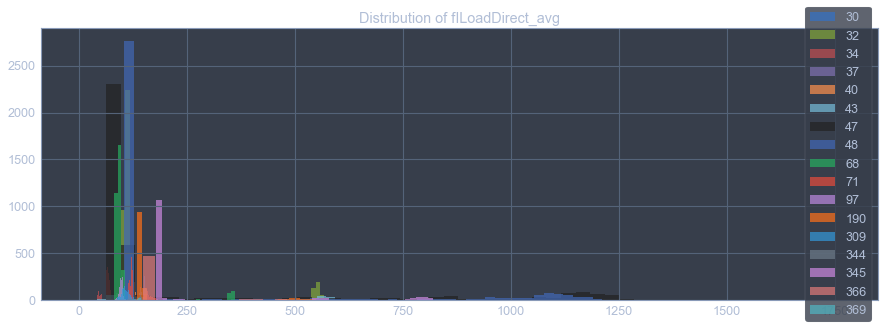

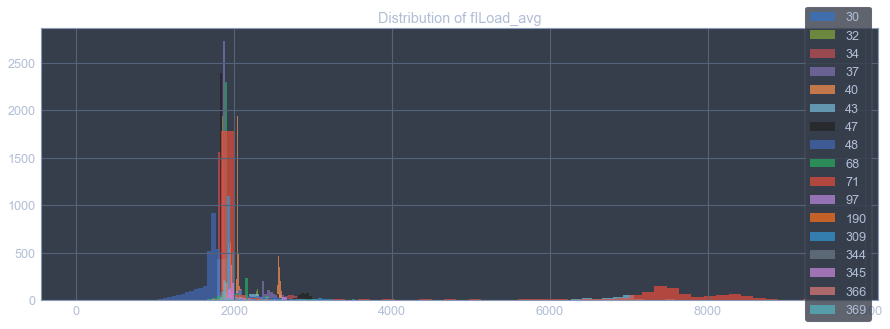

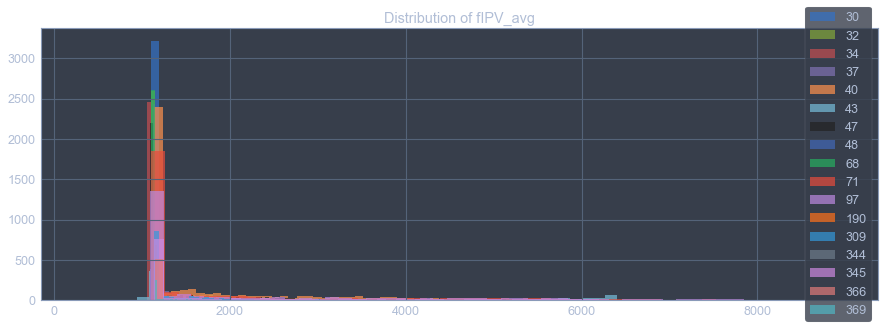

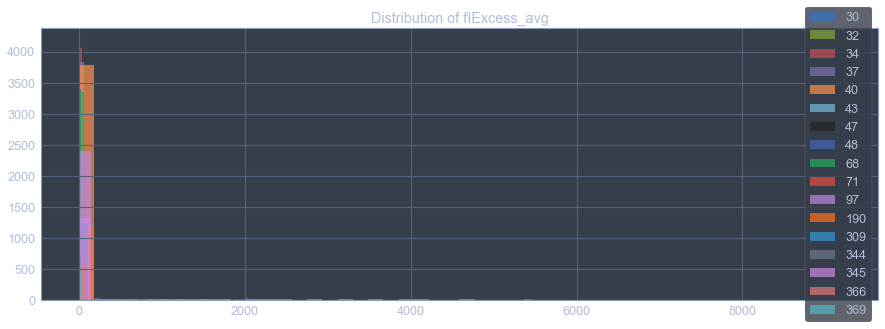

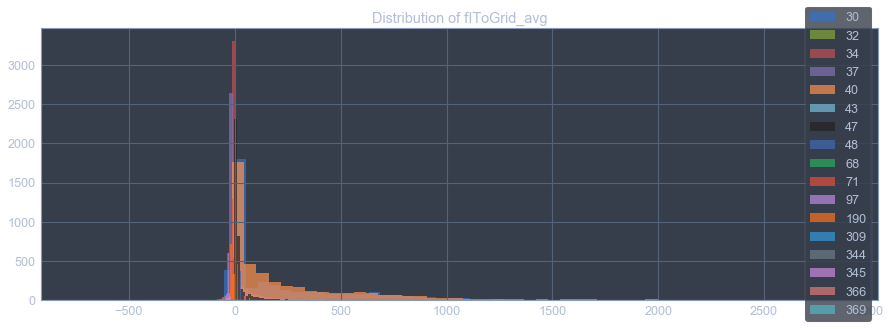

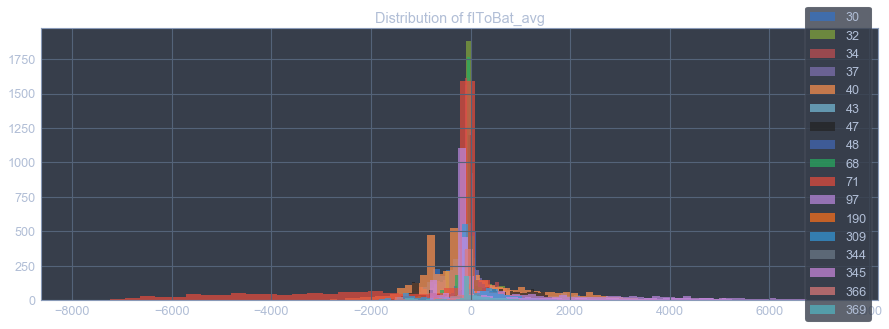

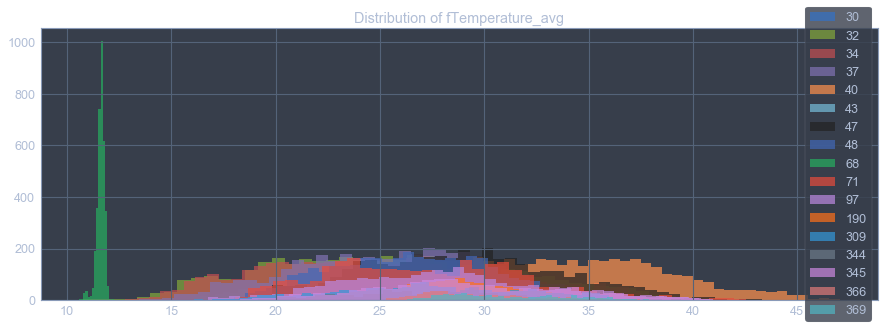

In [8]:
for var in currents:
    plt.figure(figsize=(15, 5))
    for station in stations:
        plt.hist(data_hourly.loc[station, var].dropna().values, bins=50, label=str(station), alpha=0.7)
        
    plt.title('Distribution of {}'.format(var))
    plt.legend(loc='right')
    plt.show()

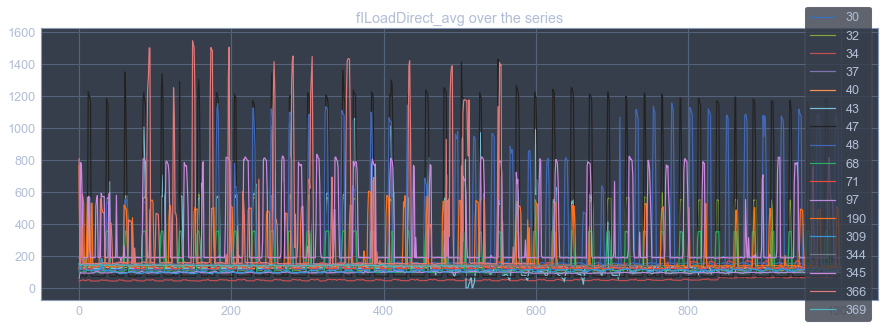

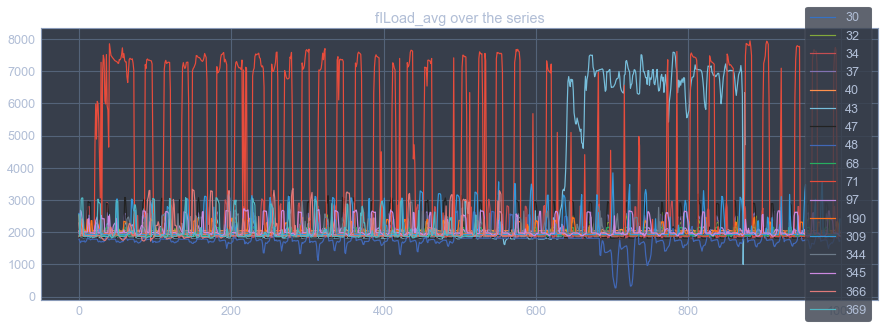

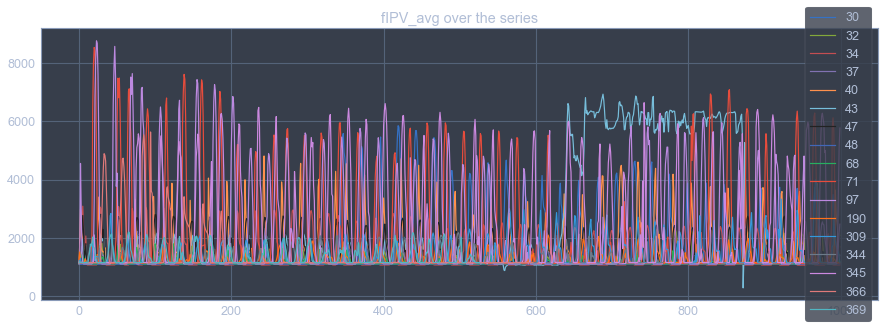

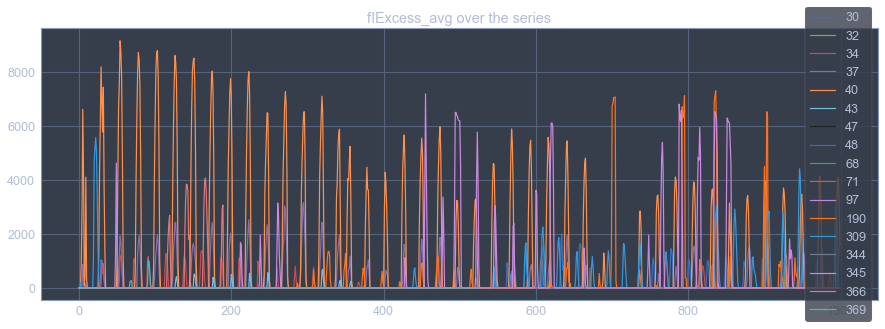

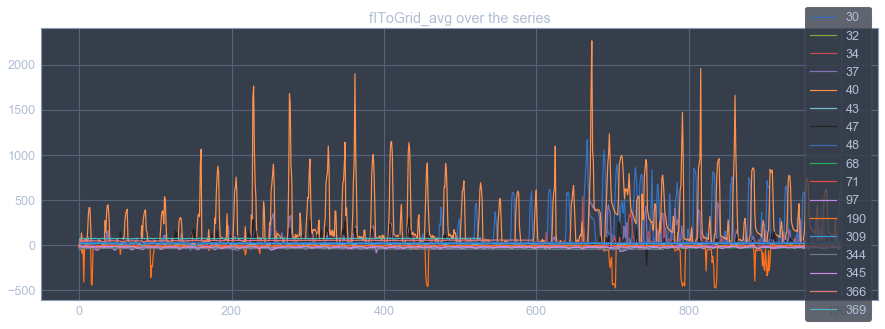

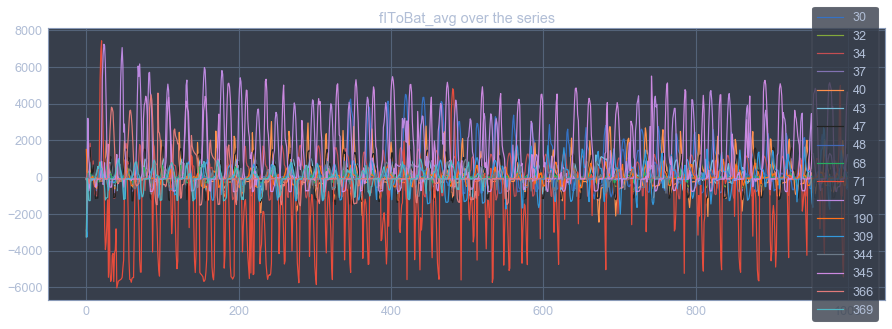

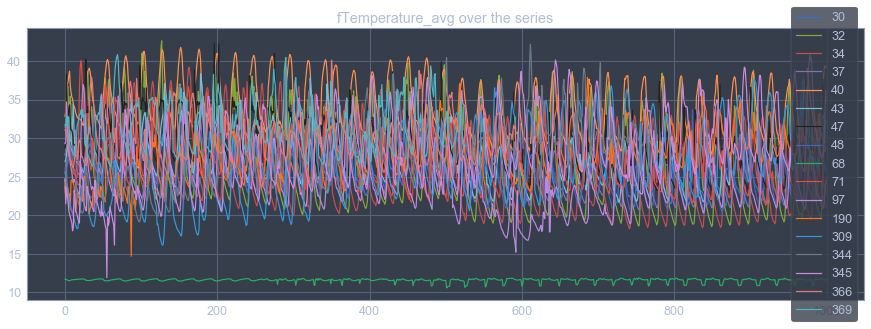

In [9]:
for var in currents:
    plt.figure(figsize=(15, 5))
    for station in stations:
        plt.plot(data_hourly.loc[station, var].iloc[:1000].values, label=station)
        
    plt.title('{} over the series'.format(var))
    plt.legend(loc='right')
    plt.show()

### Exploration ideas
1. - How much energy doesn't get used because of the battery being full and nobody buying energy?

In [63]:
data['fILoad_avg'].groupby('solbox_id').sum()

solbox_id
190    69811330.98
30    205640734.13
309    86372551.94
32    217659714.76
34    222398882.83
344    38941165.74
345    80080339.66
366    32747086.35
369    28503598.06
37    223928882.74
40    255828065.35
43     70517306.56
47    209942208.30
48    169176563.48
68    184663934.33
71    279984506.81
97    127742884.81
Name: fILoad_avg, dtype: float64

In [64]:
data['fIExcess_avg'].groupby('solbox_id').sum()

solbox_id
190    6142705.36
30    15993500.48
309   13666258.34
32      156635.19
34     4056492.67
344     201152.16
345    9363172.98
366    1633134.41
369     106171.30
37    10777028.89
40    41701122.50
43      247202.47
47       44646.31
48     4110832.81
68     3487235.98
71       30712.29
97     2759011.03
Name: fIExcess_avg, dtype: float64

In [66]:
#1. - How much energy doesn't get used because of the battery being full and nobody buying energy?
print(data['fIExcess_avg'].groupby('solbox_id').sum() / data['fILoad_avg'].groupby('solbox_id').sum())
print(data['fIExcess_avg'].groupby('solbox_id').sum().sum() / data['fILoad_avg'].groupby('solbox_id').sum().sum())

solbox_id
190   0.09
30    0.08
309   0.16
32    0.00
34    0.02
344   0.01
345   0.12
366   0.05
369   0.00
37    0.05
40    0.16
43    0.00
47    0.00
48    0.02
68    0.02
71    0.00
97    0.02
dtype: float64
0.04571875775270569


In [13]:
## Modelling